In [ ]:
import os
import sys

def download(name, model, iters):
    trained_policy = '{}-{}.iter={}.npz'.format(name, model, iters)
    if not os.path.exists('.policy/{}'.format(trained_policy)):
        print 'download the model from HPC server'
        os.system('scp mercer:/scratch/jg5223/exp/.policy/{} .policy/'.format(trained_policy))
    print 'done'
# m ='model_wmt15_bpe2k_uni_en-ru_rev.npz'    
# download('160920-225547', m, '44400')
# download('160920-225339', m, '33600') 
# download('160920-230514', m, '95600')
# download('160920-225917', m, '68000')
# download('160920-230503', m, '48200')
# download('160920-225454', m, '45200')

# m ='model_wmt15_bpe2k_uni_en-de_rev.npz' 
# download('160925-000643', m, '24400')
# download('160925-000657', m, '10400')
# download('160925-000642', m, '8000') 
# download('160925-000735', m, '22200')
# download('160925-000751', m, '26200')
# download('160925-000811', m, '18800')

# max model 172 160917-175503 Iter=34400 AP=0.3 0.14121125914
# max model 262 160917-001117 Iter=52400 AP=0.5 0.157379802964
# max model 141 160917-175423 Iter=28200 AP=0.7 0.15857511208
# max model 67 160917-175657 Iter=13400 CW=5.0 0.160038686998
m ='model_wmt15_bpe2k_uni_en-de.npz' 
download('160917-175503', m, '34400')
download('160917-001117', m, '52400')
download('160917-175423', m, '28200') 
download('160917-175657', m, '13400')



In [7]:
# %load simultrans_train.py
"""
Simultaneous Machine Translateion: Training with Policy Gradient

"""
import argparse
import os
import cPickle as pkl

from bleu import *
from nmt_uni import *
from policy import Controller as Policy
from utils import Progbar, Monitor
from data_iterator import check_length, iterate

from simultrans_model_clean import simultaneous_decoding
from simultrans_model_clean import _seqs2words, _bpe2words, _padding
from config import rl_config
    
import time

numpy.random.seed(19920206)
timer = time.time


config       = rl_config()
options_file = config['option']
model        = config['model']
WORK         = config['workspace']
id, remote   = None, False

# check hidden folders
paths = ['.policy', '.pretrained', '.log', '.config', '.images', '.translate']
for p in paths:
    p = WORK + p
    if not os.path.exists(p):
        os.mkdir(p)

if id is not None:
    fcon = WORK + '.config/{}.conf'.format(id)
    if os.path.exists(fcon):
        print 'load config files'
        policy, config = pkl.load(open(fcon, 'r'))

# ============================================================================== #
# load model model_options
# ============================================================================== #
_model = model.split('/')[-1]

if options_file is not None:
    with open(options_file, 'rb') as f:
        options = pkl.load(f)
else:
    with open('%s.pkl' % model, 'rb') as f:
        options = pkl.load(f)

print 'merge configuration into options'
for w in config:
    # if (w in options) and (config[w] is not None):
    options[w] = config[w]

print 'load options...'
for w, p in sorted(options.items(), key=lambda x: x[0]):
    print '{}: {}'.format(w, p)

# load detail settings from option file:
dictionary, dictionary_target = options['dictionaries']

# load source dictionary and invert
with open(dictionary, 'rb') as f:
    word_dict = pkl.load(f)
word_idict = dict()
for kk, vv in word_dict.iteritems():
    word_idict[vv] = kk
word_idict[0] = '<eos>'
word_idict[1] = 'UNK'

# load target dictionary and invert
with open(dictionary_target, 'rb') as f:
    word_dict_trg = pkl.load(f)
word_idict_trg = dict()
for kk, vv in word_dict_trg.iteritems():
    word_idict_trg[vv] = kk
word_idict_trg[0] = '<eos>'
word_idict_trg[1] = 'UNK'

options['pre'] = config['pre']

# ========================================================================= #
# Build a Simultaneous Translator
# ========================================================================= #

# allocate model parameters
params = init_params(options)
params = load_params(model, params)
tparams = init_tparams(params)

# print 'build the model for computing cost (full source sentence).'
trng, use_noise, \
_x, _x_mask, _y, _y_mask, \
opt_ret, \
cost, f_cost = build_model(tparams, options)
print 'done'

# functions for sampler
f_sim_ctx, f_sim_init, f_sim_next = build_simultaneous_sampler(tparams, options, trng)

# function for finetune the underlying model
if options['finetune']:
    ff_init, ff_cost, ff_update = build_simultaneous_model(tparams, options, rl=True)
    funcs = [f_sim_ctx, f_sim_init, f_sim_next, f_cost, ff_init, ff_cost, ff_update]

else:
    funcs = [f_sim_ctx, f_sim_init, f_sim_next, f_cost]


# check the ID:
options['base'] = _model
agent     = Policy(trng, options,
                   n_in=options['readout_dim'] + 1 if options['coverage'] else options['readout_dim'],
                   n_out=3 if config['forget'] else 2,
                   recurrent=options['recurrent'], id=id)

# make the dataset ready for training & validation
trainIter = TextIterator(options['datasets'][0], options['datasets'][1],
                         options['dictionaries'][0], options['dictionaries'][1],
                         n_words_source=options['n_words_src'], n_words_target=options['n_words'],
                         batch_size=config['batchsize'],
                         maxlen=options['maxlen'])

train_num = trainIter.num

validIter = TextIterator(options['valid_datasets'][0], options['valid_datasets'][1],
                         options['dictionaries'][0], options['dictionaries'][1],
                         n_words_source=options['n_words_src'], n_words_target=options['n_words'],
                         batch_size=20, cache=10,
                         maxlen=1000000)

valid_num = validIter.num
print 'training set {} lines / validation set {} lines'.format(train_num, valid_num)
print 'use the reward function {}'.format(chr(config['Rtype'] + 65))








Using gpu device 3: GeForce GTX TITAN X (CNMeM is disabled, cuDNN 5005)


merge configuration into options
load options...
Rtype: 10
act_mask: True
alpha_c: 0.0
batch_size: 64
batchsize: 10
clip_c: 1.0
coverage: False
datasets: ['/misc/kcgscratch1/ChoGroup/thoma_data/simul_trans/un16/train.un16.en-zh.en.c0.tok.clean.bpe20k.np', '/misc/kcgscratch1/ChoGroup/thoma_data/simul_trans/un16/train.un16.en-zh.zh.c0.tok.clean.bpe20k.np']
decay_c: 0.0
decoder: gru_cond
dictionaries: ['/misc/kcgscratch1/ChoGroup/thoma_data/simul_trans/un16/train.un16.en-zh.en.c0.tok.clean.bpe20k.vocab.pkl', '/misc/kcgscratch1/ChoGroup/thoma_data/simul_trans/un16/train.un16.en-zh.zh.c0.tok.clean.bpe20k.vocab.pkl']
dim: 1028
dim_word: 512
dispFreq: 50
encoder: gru
finetune: True
finish_after: 10000000
forget: False
full_att: False
gamma: 1
layernorm: False
lr_model: 2e-05
lr_policy: 0.0002
lrate: 0.0001
max_epochs: 5000
maxlen: 50
maxsrc: 10
model: /misc/kcgscratch1/ChoGroup/thoma_data/simul_trans/.pretrained/model_un16_bpe2k_uni_en-zh.npz
n_words: 20000
n_words_src: 20000
optimizer: adade

In [44]:
# ================================================================================= #
# Main Loop: Run
# ================================================================================= #
print 'Start Simultaneous Translator...'
monitor = None
if remote:
    monitor = Monitor(root='http://localhost:9000')

# freqs
save_freq     = 200
sample_freq   = 10
valid_freq    = 200
valid_size    = 200
display_freq  = 50
finetune_freq = 5

history, last_it = agent.load()
action_space = ['W', 'C', 'F']
Log_avg = {}
time0 = timer()

pipe = OrderedDict()
for key in ['x', 'x_mask', 'y', 'y_mask', 'c_mask']:
    pipe[key] = []

def _translate(src, trg, samples=None, train=False,
               greedy=False, show=False, full=False):
    time0 = time.time()
    if full:
        options1 = copy.copy(options)
        options1['finetune'] = False
    else:
        options1 = options

    ret   = simultaneous_decoding(
            funcs, agent, options1,
            src, trg, word_idict_trg,
            samples, greedy, train)

    if show:
        info   = ret[1]
        values = [(w, float(info[w])) for w in info if w != 'advantages']
        print ' , '.join(['{}={:.3f}'.format(k, f) for k, f in values]),
        print '...{}s'.format(time.time() - time0)

    return ret




Start Simultaneous Translator...


In [9]:
srcs, trgs = trainIter.next()

In [10]:
for s in srcs:
    print len(s),

43 60 44 42 47 44 51 43 41 45


In [45]:
# training set sentence tuning
new_srcs, new_trgs = [], []
for src, trg in zip(srcs, trgs):
    if len(src) <= options['s0']:
        continue  # ignore when the source sentence is less than sidx.
    else:
        new_srcs += [src]
        new_trgs += [trg]

srcs, trgs = new_srcs, new_trgs
statistics, info = _translate(srcs, trgs, train=True, show=True, greedy=False)



Adv=0.197 , B_loss=0.014 , p(COMMIT)=0.454 , p(WAIT)=0.546 , StartR=0.061 , J=-0.111 , Delay=0.611 , a_cost=-4.762 , Entropy=-0.027 , Quality=0.034 ...7.75953602791s


In [46]:
for a in statistics['attentions']:
    print '{}: {}'.format(len(a), a[0].shape),

3: (61,) 2: (61,) 2: (61,) 3: (61,) 3: (61,) 4: (61,) 4: (61,) 3: (61,) 4: (61,) 6: (61,) 5: (61,) 5: (61,) 5: (61,) 5: (61,) 9: (61,) 7: (61,) 6: (61,) 7: (61,) 8: (61,) 9: (61,) 11: (61,) 13: (61,) 10: (61,) 10: (61,) 11: (61,) 10: (61,) 8: (61,) 9: (61,) 8: (61,) 10: (61,) 15: (61,) 13: (61,) 14: (61,) 18: (61,) 13: (61,) 15: (61,) 13: (61,) 13: (61,) 15: (61,) 11: (61,) 16: (61,) 14: (61,) 15: (61,) 11: (61,) 16: (61,) 12: (61,) 16: (61,) 12: (61,) 19: (61,) 18: (61,) 13: (61,) 17: (61,) 15: (61,) 19: (61,) 18: (61,) 14: (61,) 16: (61,) 17: (61,) 15: (61,) 18: (61,) 18: (61,) 16: (61,) 17: (61,) 24: (61,) 20: (61,) 19: (61,) 23: (61,) 19: (61,) 19: (61,) 22: (61,) 22: (61,) 18: (61,) 18: (61,) 27: (61,) 30: (61,) 24: (61,) 27: (61,) 18: (61,) 26: (61,) 24: (61,) 29: (61,) 28: (61,) 26: (61,) 32: (61,) 25: (61,) 39: (61,) 34: (61,) 29: (61,) 32: (61,) 33: (61,) 33: (61,) 26: (61,) 37: (61,) 40: (61,) 37: (61,) 44: (61,) 50: (61,) 60: (61,) 59: (61,) 70: (61,)


In [50]:
it = 1

# obtain the translation results
csamples = _bpe2words(
        _seqs2words(statistics['sample'], word_idict_trg,
                    statistics['action'], 1))
csources =  _bpe2words(
        _seqs2words(statistics['SWord'], word_idict,
                    statistics['action'], 0))
sources  = _seqs2words(statistics['SWord'], word_idict)
samples  = _seqs2words(statistics['sample'], word_idict_trg)
targets  =  _bpe2words(
        _seqs2words(statistics['TWord'], word_idict_trg))

c  = 0
for j in range(20, 40):
    print '--Id: {}'.format(j)
    print 'source: ', csources[j]
    print 'sample: ', csamples[j]
    print 'source: ', sources[j]
    print 'sample: ', samples[j]
    print 'target: ', targets[j]
    print 'quality:', statistics['track'][j][0]
    print 'delay:',   statistics['track'][j][1]
    print 'reward:',  statistics['track'][j][2]




--Id: 20
source:  He noted that most of the participants in the symposium were of the view that host countries should be able to regulate FDI so that they could choose their own particular mix of policies and conditions relating to FDI keeping in mind their developmental needs
sample:  他 指出 大多数 成员 的 作者 多半 都 是 参与者
source:  He noted that most of the participants in the symposium were of the view that host countries should be able to regulate FDI so that they could choose their own particular mix of policies and conditions relating to FDI keeping in mind their developmental needs
sample:  他 指出 大多数 成员 的 作者 多半 都 是 参与者
target:  他 指出 大多数 与会者 认为 接受 投资 的 国家 应该 能够 管理 外国 直接 投资 以便 能 结合 自己 的 发展 需要 选择 有 自己 特点 的 外国 直接 投资 政策 和 条件 的 组合
quality: 0.0013957233579
delay: 0.740259730646
reward: 0.0027914467158
--Id: 21
source:  The Special Representative noted that the use of criminal charges such as UNK encouraging hatred of the State UNK and UNK distributing fal@@ se@@ hoods and r@@ um@@ ors UNK frequentl

In [14]:
def is_str(s):
    return isinstance(s, basestring)
print is_str(samples[j])
print samples[j]
print samples[j].decode('utf-8')

True
b 用以 加强 主席团 / 小组 提出 的 新 议题
b 用以 加强 主席团 / 小组 提出 的 新 议题


In [26]:
import matplotlib
# reload(matplotlib) 

# import matplotlib.font_manager as fm
from matplotlib import pyplot as plt
from matplotlib import rc
from matplotlib import rcParams

# #rc('font',**{'family':'WenQuanYi Micro Hei', 'weight': 'normal'})
# #rc('font', size=8)
# plot.rcParams['axes.unicode_minus']=False 
import copy
import seaborn as sns
import pandas as pd
sns.set(context="paper", font="monospace", style='whitegrid')

# rc('text', usetex=True)
# rc('text.latex',unicode=True)
# rc('text.latex',preamble='\usepackage[utf8]{inputenc}')
# rc('text.latex',preamble='\usepackage[russian]{babel}')
# rc('text.latex',preamble='\usepackage[german]{babel}')
# rc('text.latex',preamble='\usepackage[ngerman]{babel}')
myfont = matplotlib.font_manager.FontProperties(
    fname='./utils/msyh.ttf') 

matplotlib.rcParams['axes.unicode_minus'] = False 
matplotlib.rcParams['ytick.labelsize'] = 11
matplotlib.rcParams['xtick.labelsize'] = 11 

def heatmap3(sources, refs, trans, actions, idx, atten=None, full_atten=None, savefig=True, name='test', info=None, show=False):
    source = ['*'] + [s.strip() for s in sources[idx].decode('utf8').replace('@@', '--').split()] + ['||']
    target = ['*'] + [s.strip() for s in trans[idx].decode('utf8').replace('@@', '--').split()] + ['||'] + ['*']
    action = actions[idx]
   
    flag   = 0
    if atten:
        attention = numpy.array(atten[idx])
    else:
        attention = None

    if full_atten:
        fullatten = numpy.array(full_atten[idx])
    else:
        fullatten = None
    
    def track(acts, data, annote):
        x, y, z = 0, 0, 0
        for a in acts:
            x += (a == 1)
            y += (a == 0)
            z += (a == 2)

            # data[y + 1, x]   = 1
            # data[z, x + 1]   = 1
            # annote[y, x] = 'W' if a == 0  else 'C'

        return data, annote
    # print target
    
    data       = numpy.zeros((len(source), len(target)))
    annote     = numpy.chararray(data.shape, itemsize=8)
    annote[:]  = '' 
    data, annote  = track(action, data, annote)
    data[1, 0] = 1
    
    def draw(data_t, ax, attention=None):
        
        data   = copy.copy(data_t)
        data[1:-1, 1:-1] += attention.T
        d  = pd.DataFrame(data=data, columns=target, index=source)
        # p  = sns.diverging_palette(220, 10, as_cmap=True)
        g  = sns.heatmap(d, mask=(data==0), square=True, cbar=False, 
                         linewidths=0.1, ax=ax, annot=annote, fmt='s')
        g.xaxis.tick_top()
   
        for tick in ax.get_xticklabels():
            tick.set_rotation(60)
        for tick in ax.get_yticklabels():
            tick.set_rotation(0)
        for label in ax.get_xticklabels():
            label.set_fontproperties(myfont)
        
        ax.grid(True)
        
    if full_atten:
        f, [ax1, ax2] = plt.subplots(1, 2, figsize=(22, 11))
        f.set_canvas(plot.gcf().canvas)
    
        draw(data, ax1, attention)
        draw(data, ax2, fullatten)
    else:
        f, ax1 = plt.subplots(1, 1, figsize=(22, 22))
        f.set_canvas(plt.gcf().canvas)
    
        draw(data, ax1, attention)

    
    if savefig:
        if not os.path.exists('.images/M_{}'.format(name)):
            os.mkdir('.images/M_{}'.format(name))

        filename = 'Idx={}||'.format(info['index'])
        for w in info:
            if w is not 'index':
                filename += '.{}={:.2f}'.format(w, float(info[w]))

        # print 'saving...'
        plt.savefig('.images/M_{}'.format(name) + '/{}'.format(filename) + '.pdf', dpi=100)
    
    if show:
        plt.show()

    # print 'plotting done.'
    plt.close()
 

(41,)


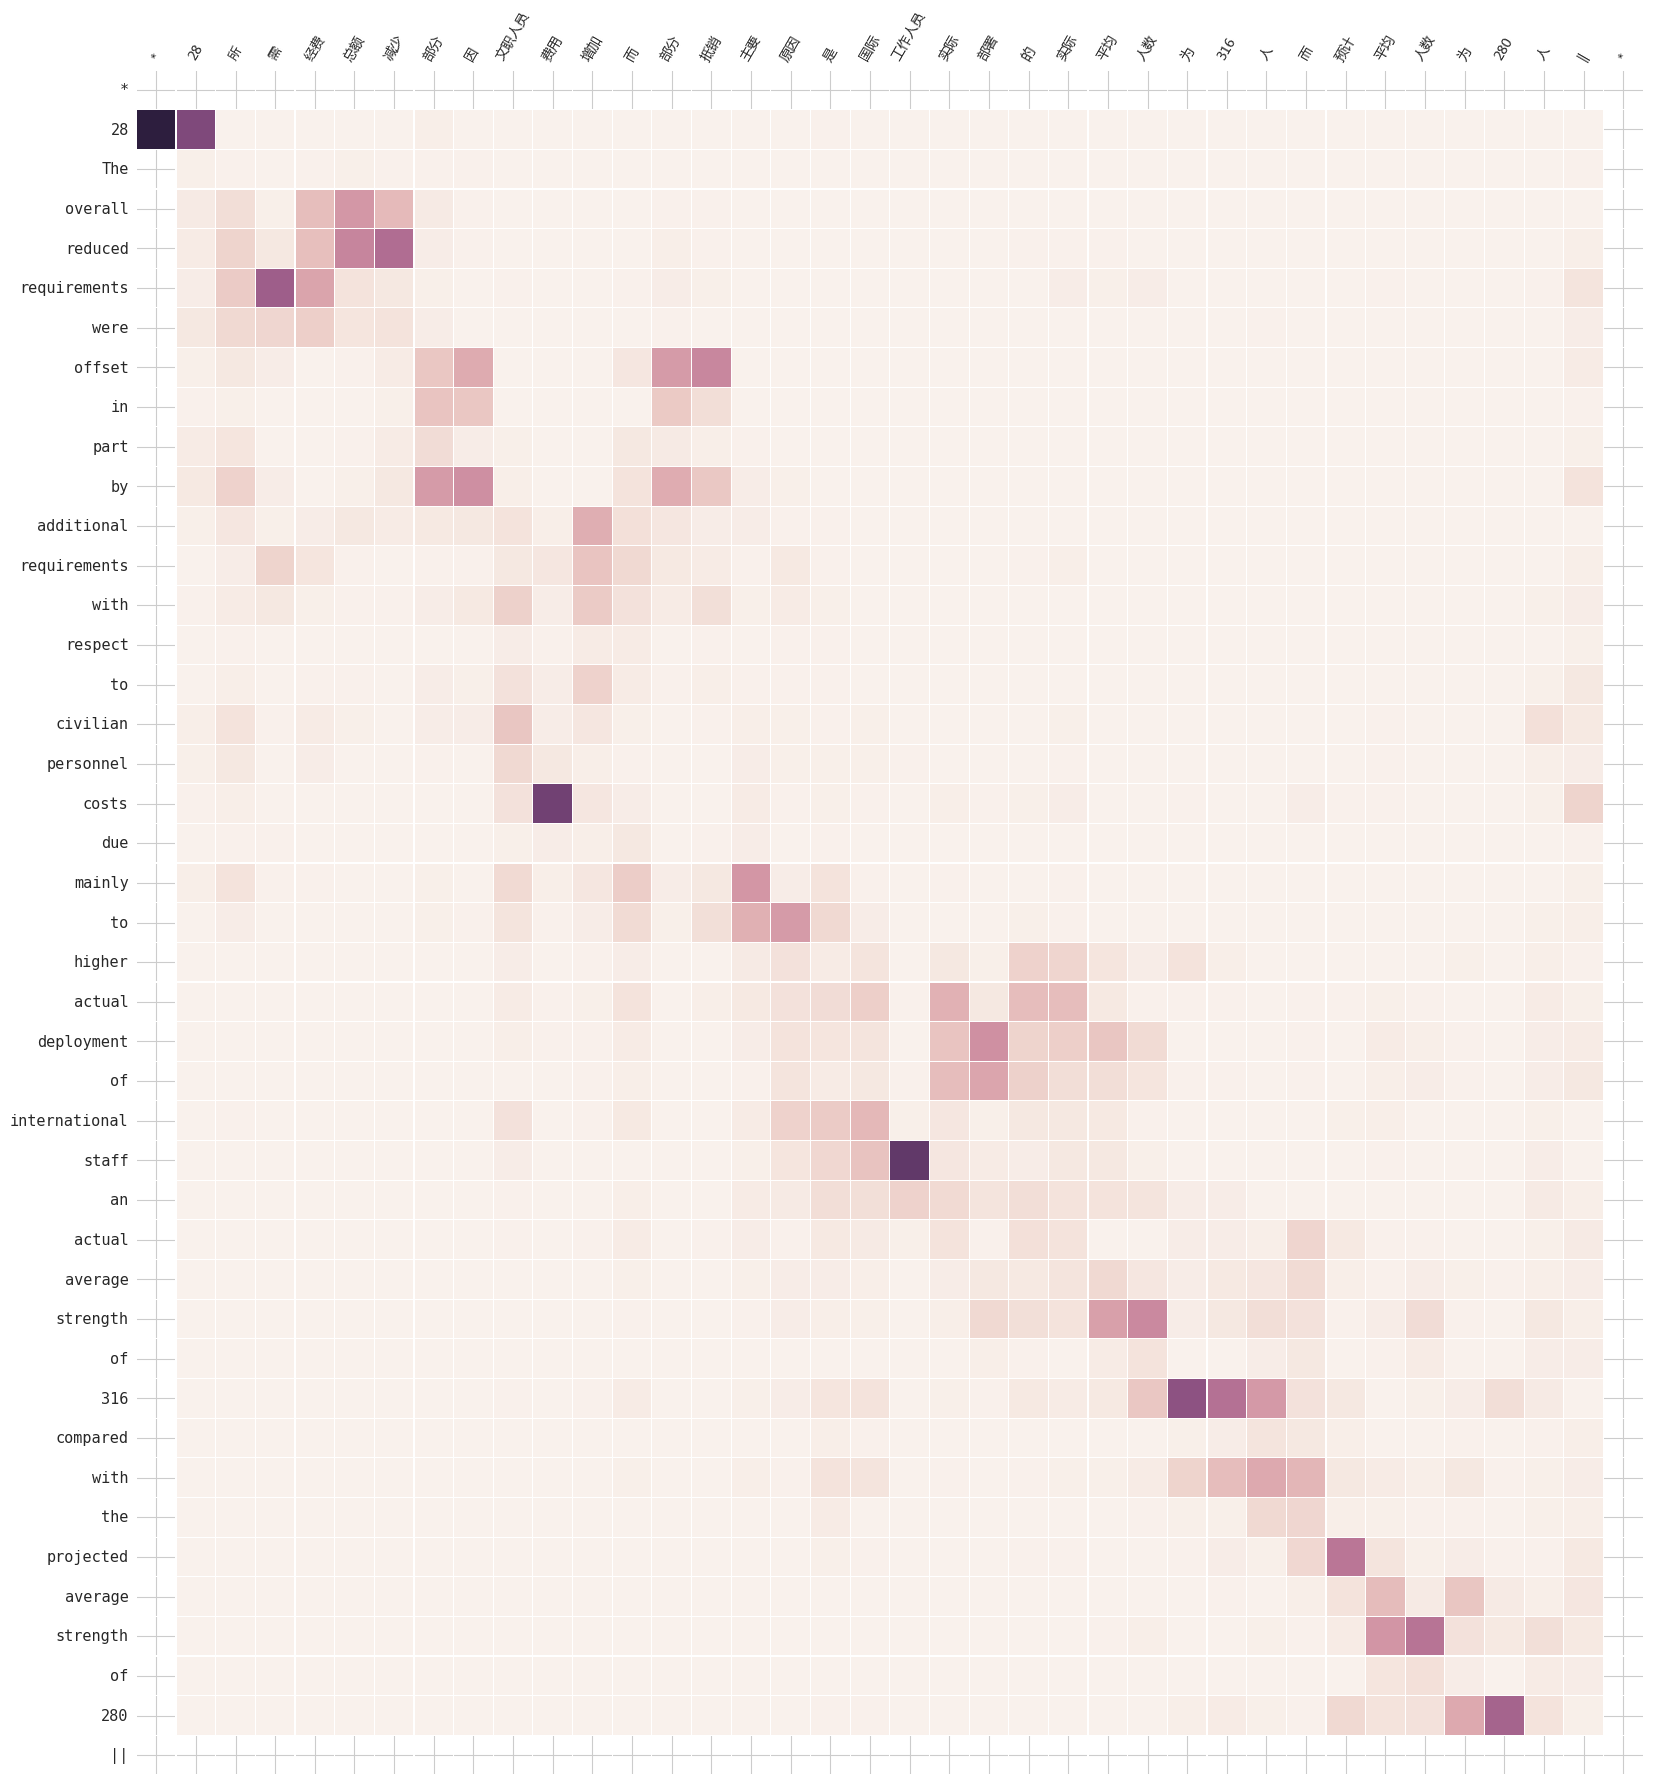

In [35]:

src = [sources[j]]
L   = len(src[0].split())
trs = [samples[j]]
act = [statistics['action'][j]]
att = [[a[:L] for a in statistics['attentions'][j]]]
print att[0][0].shape
heatmap3(src, None, trs, act, 0, att, None, name='test', info={'index': 'test'}, show=True, savefig=False)

(41,)


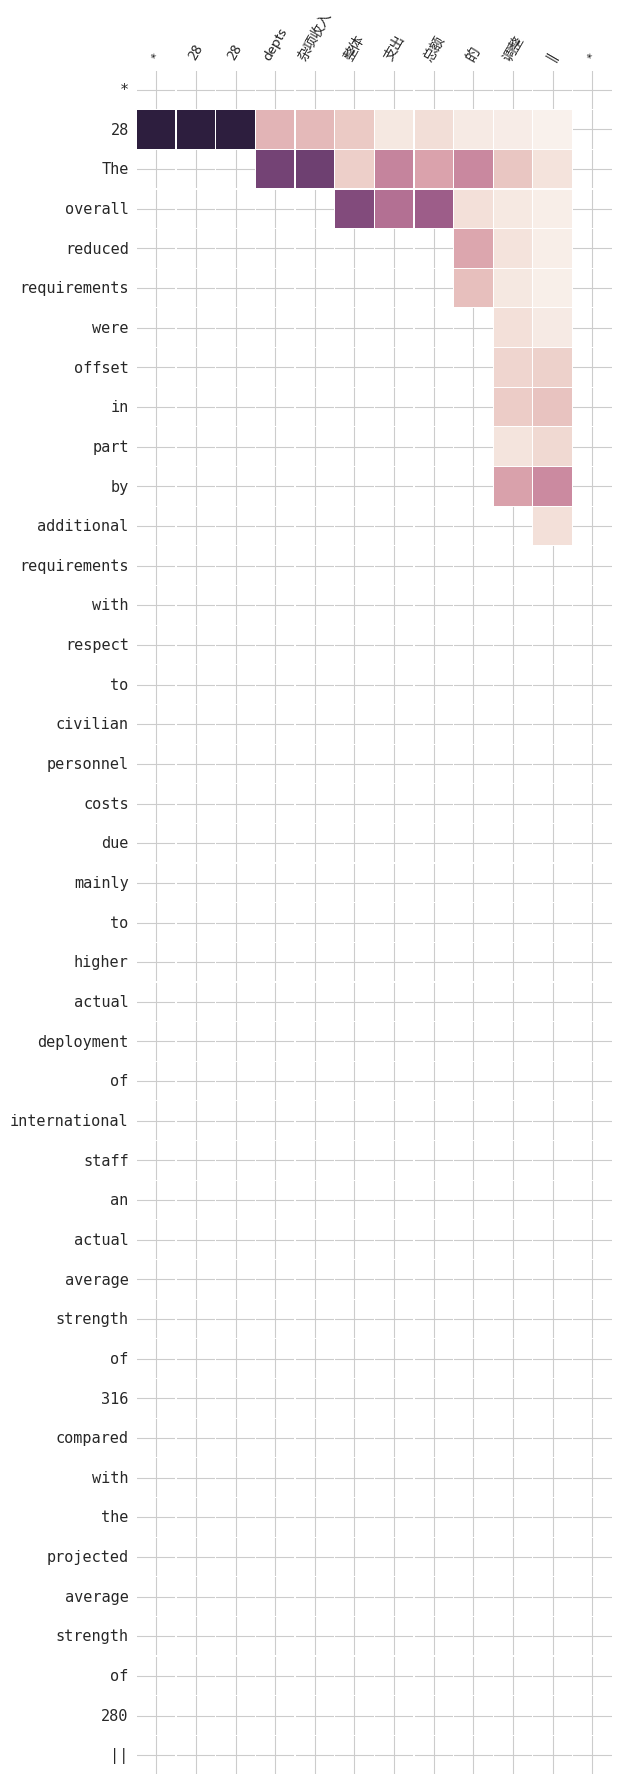

In [51]:
j = 25
src = [sources[j]]
L   = len(src[0].split())
trs = [samples[j]]
act = [statistics['action'][j]]
att = [[a[:L] for a in statistics['attentions'][j]]]
print att[0][0].shape
heatmap3(src, None, trs, act, 0, att, None, name='test', info={'index': 'test'}, show=True, savefig=False)

In [15]:
# -*- coding: utf-8 -*-   
from pylab import *  
 
# t = arange(-5*pi, 5*pi, 0.01)  
# y = sin(t)/t  
# plt.plot(t, y)  
# plt.title(u'这里写的是中文',fontproperties=myfont) #指定字体  
# plt.xlabel(u'X坐标',fontproperties=myfont)  
# plt.ylabel(u'Y坐标',fontproperties=myfont)  
# plt.show()  